In [410]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import corner_harris, corner_peaks
from sklearn.cluster import DBSCAN

Define Functions

In [422]:
def isSegment(p1,p2, bin_im, ksize, sample_num, pvote, cvote):
    x1, y1 = p1
    x2, y2 = p2
    
    x1, x2, y1, y2 = int(x1), int(x2), int(y1), int(y2)
    
    x_disp = abs(x2 - x1)
    y_disp = abs(y2 - y1)
    
    x_step = x_disp / (sample_num + 1)
    y_step = y_disp / (sample_num + 1)
    
    vote = 0
    
    xstart = 0
    ystart = 0
    if x2 >= x1:
        xstart = x1
        ystart = y1
        if y2 < y1:
            y_step = -y_step
    else:
        xstart = x2
        ystart = y2
        if y2 > y1:
            y_step = -y_step
        
    

    for mult in range(1, sample_num + 1):  
        xc, yc = int(xstart + mult*x_step), int(ystart + mult*y_step)
        view = bin_im[xc - ksize: xc + ksize, yc - ksize: yc + ksize]
         
        color = (0,255,0)
        if np.sum(view) >= pvote:
            vote += 1 
            color = (0,0,255)
#             print "OUTPUT" + str(np.sum(view)) + " " + str(pvote)
#         cv2.circle(im_display, (int(xc), int(yc)), ksize, color, thickness=1, lineType=8, shift=0) 

#     print("OUTPUT",vote, cvote)
    return vote >= cvote

In [423]:
def getCorners(img):   
    gray = np.float32(img)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)
    dst = cv2.dilate(dst,None)

    return corners

In [424]:
def getSegments(img, corners, ksize, sample_num, pvote, cvote):
    segment = []
    for i in range(len(corners)):
        for j in range(i+1,len(corners)):
            c1,c2 = tuple(corners[i]), tuple(corners[j])
            if isSegment(c1, c2, img, ksize, sample_num, pvote, cvote): 
                segment.append((c1,c2))
#                   segments.append((tuple(c1), tuple(c2)))
#                
#     print "segment length:"+str(len(segment))
    return segment


In [442]:
def pointCluster(points):
    clusters = DBSCAN(eps=4, min_samples=2).fit(points)
    
    labels = clusters.labels_#classes (integers)
    comp = points
    
    print("labels", len(labels))
    print("comp", len(comp))
    
    labelSum = {}
    for i, l in enumerate(labels):
        point = comp[i]
        
        c = 0
        n = (0.0, 0.0)
        if l == -1:
            labelSum[-1 * i] = (comp[i], 1)
            
        if l in labelSum:
            n, c = labelSum.get(l)
        
        c+=1
        
        nn = (point[0] + n[0], point[1] + n[1])
        

        labelSum[l] = (nn, c)
    
    corners = []
    for label, t in labelSum.iteritems():
        center = (int(t[0][0] / t[1]), int(t[0][1] / t[1]))
        corners.append(center)
    return corners
        
        

## Test Functions

##### hyperparameters

In [459]:
#BEST IS 3, 5, 18, 25

KSIZE = 4
PVOTE = 5
CVOTE = 18
SAMPLE_NUM = 25

img_directory = "images/"

##### test script

In [471]:
im = cv2.imread(img_directory + "butterfly_CP.jpg")
im_display = np.zeros(im.shape, dtype = np.uint8)
im_display.fill(255)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# im_display = im.copy()

im_orig = im.copy()

# "Preps Image to be displayed" - Lillian

im = np.invert(im)
im[im > 200] = 1
im[im != 1] = 0




14904


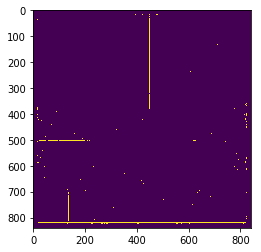

In [472]:
plt.imshow(im)
print(np.sum(im))

In [463]:
# corners = getCorners(im_orig)
corners = corner_peaks(corner_harris(im_orig, k=0.2))
corners = pointCluster(corners)
segments = getSegments(im, corners, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)

print(len(corners))

# for c in corners:
#     print c
# print("DETECTED SEGMENTS")
for c1,c2 in segments:
    cv2.line(im_display, c1, c2, (0,0,255),1) 

# for c1, c2 in segments:
#     if c1 == segments[0][0] or c2 == segments[0][0]:
#         print "Points:", c1, c2


# # cv2.line(im_display, segments[1][0], segments[1][1], (0,255,0), 3)

# cv2.line(im_display, segments[1][0], segments[1][1], (0,255,0), 3)

    # print("("+ str(i) +","+str(segments.get(i))+")")

# cv2.circle(im_display, (int(196.46725), int(197.349)), 2, (0,255,0), thickness=1, lineType=8, shift=0) 
# test = isSegment((395.45193, 2),(340.5281, 256.2259), im, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)
# test = isSegment((395.45193, 200),(340.5281, 256.2259), im, ksize = KSIZE, sample_num = SAMPLE_NUM, pvote = PVOTE, cvote = CVOTE)
# #print test

cv2.imwrite(img_directory + "bfly" + str(KSIZE) +  str(PVOTE) + str(CVOTE) + str(SAMPLE_NUM) + ".png", im_display)


('labels', 48)
('comp', 48)
21


True